In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter 9: Pytorchによる転移学習
ここではpytorchによる転移学習の実装を行います．<br>
転移学習とは，事前に他のデータセットで学習した深層学習モデルを特徴量生成器（次元削減器）として使用することで学習用データが少ない時でも過学習しないモデルを作るといったアプローチです<br>
今回は[Chapter8](./Chapter8.ipynb)で作成した分類器を用いて「０」「１」を分類するモデルを転移学習で作成していきます．<br>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

1.9.1


データセットの用意<br>
**MNISTデータセットから「０」と「１」のみを抽出します**

In [3]:
#データの前処理を行うクラスインスタンス
transform = transforms.Compose(
    [transforms.Resize((16, 16)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

batch_size = 100

#使用するtrainデータセット
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
mask = ((trainset.targets == 1) | (trainset.targets == 0))
trainset.data = trainset.data[mask]
trainset.targets = trainset.targets[mask]
#データ分割
trainset, _ = torch.utils.data.random_split(trainset, [10000, len(trainset)-10000])
print(len(trainset))

#trainデータをbatchごとに逐次的に取り出してくれるクラスインスタンス
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True)

#使用するtestデータセット（以下略）
testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
mask = ((testset.targets == 1) | (testset.targets == 0))
testset.data = testset.data[mask]
testset.targets = testset.targets[mask]

testset, _ = torch.utils.data.random_split(testset, [1000, len(testset)-1000])
print(len(testset))

testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False)

10000
1000


In [4]:
import torch.nn.functional as F
#モデルの定義
class NeuralNet(torch.nn.Module):
    def __init__(self, n_input=256, n_hidden=16, n_output=8):
        super(NeuralNet, self).__init__()
        self.n_input = n_input
        
        #一層目と二層目の重み行列の定義
        self.l1 = torch.nn.Linear(n_input,  n_hidden, bias = True)
        self.l2 = torch.nn.Linear(n_hidden, n_hidden, bias = True)
        self.l3 = torch.nn.Linear(n_hidden, n_output, bias = True)
        
    def forward(self, x):
        #画像データ(２次元）を1次元に落とす
        x = x.view(-1, self.n_input)
        
        #一層目の重み行列をかける
        a1 = self.l1(x)
        
        #活性化関数に通す
        h1 = F.sigmoid(a1)
        #h1 = F.relu(a1)
        
        #二層目の重み行列をかける
        a2 = self.l2(h1)
        
        #活性化関数に通す
        h2 = F.sigmoid(a2)
        #h2 = F.relu(a2)
        
        #三層目の重み行列をかける
        a3 = self.l3(h2)
        
        return a3

In [5]:
#モデルインスタンスの作成
model = NeuralNet()
'''
ここで先ほど作成して保存したモデルの情報を呼び出して今回の分類モデルのパラメータに代入します
'''
model.load_state_dict(torch.load("params/model_state_dict.pth"), strict=False)

<All keys matched successfully>

一度予測をさせてみます．\
前回作成したモデルは2~9までの数字しか分類できないので結果はトンチキなものになります

true: 1, predict: 8
true: 1, predict: 2
true: 0, predict: 5
true: 1, predict: 8
true: 0, predict: 5
true: 0, predict: 2
true: 0, predict: 5
true: 1, predict: 3
true: 0, predict: 5
true: 1, predict: 7


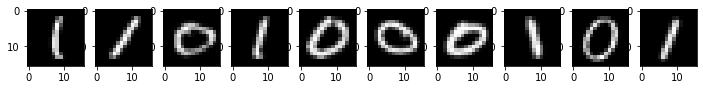

In [6]:
#モデルの予想を可視化する関数の作成
def prediction(model, num=10, c=2):
    with torch.no_grad():
        img, t = testloader.__iter__().next()
        t_pred = model(img)
        fig = plt.figure(figsize=(12,4))
        ax = []
        for i in range(num):
            print(f'true: {t[i]}, predict: {np.argmax(t_pred[i])+c}')
            ax.append(fig.add_subplot(1, num, i+1))
            ax[i].imshow(img[i, 0], cmap='gray')
        plt.show()

#学習前でどのような予測をするのかを表示
prediction(model)

転移学習の用意をします．

In [7]:
for param in model.parameters():
    param.requires_grad = False#モデルにある全てのパラメータを固定値に変換する
    
model.l3 = torch.nn.Linear(model.l3.in_features, 2)#モデルの最終層のパラメータを2クラス分類ように書き換えた上で学習パラメータに設定します
model.l3.requires_grad = True#デフォルトでTrueなので本来は書く必要ないですが明示的に

#loss関数の設定
criterion = torch.nn.CrossEntropyLoss()

#最適化手法の設定
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
#学習
epochs = 30
train_loss = []
test_loss  = []
test_acc = []
train_num_batchs = np.ceil(len(trainset) / float(batch_size))
test_num_batchs  = np.ceil(len(testset)  / float(batch_size))
for epoch in range(epochs):
    loss_sum = 0
    #trainloaderからbatchごとのデータを取り出し
    for X, t in trainloader:
        t_pred = model(X)
        loss = criterion(t_pred, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach()
    loss_sum /= train_num_batchs
    train_loss.append(float(loss_sum))
    #今回はテストデータに対する予測誤差や精度が各epochでどのように変化したのかを確かめます．
    with torch.no_grad():
        loss_sum = 0
        correct = 0
        for X, t in testloader:
            t_pred = model(X)
            loss = criterion(t_pred, t)
            loss_sum += loss.detach()
            pred = t_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(t.view_as(pred)).sum().item()
        loss_sum /= test_num_batchs
        test_loss.append(float(loss_sum))
        test_acc.append(correct/len(testloader))
    print(f'\repoch: {epoch+1}/{epochs}, train loss: {train_loss[epoch]}, test loss: {test_loss[epoch]}, test_acc: {correct}/{len(testset)}.....', end='')

epoch: 30/30, train loss: 0.2612673044204712, test loss: 0.2221093624830246, test_acc: 903/1000.......

[]

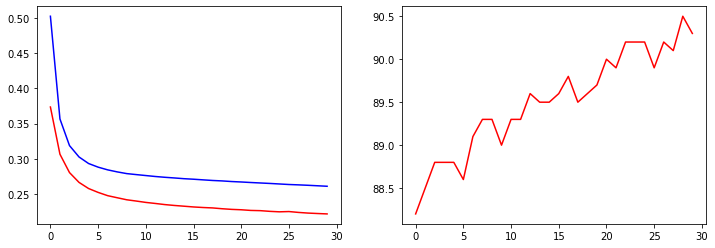

In [9]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_loss, c='b', label='train')
ax1.plot(test_loss,  c='r', label='test')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(test_acc, c='r', label='test')
plt.plot()

true: 1, predict: 0
true: 1, predict: 1
true: 0, predict: 0
true: 1, predict: 1
true: 0, predict: 0
true: 0, predict: 1
true: 0, predict: 0
true: 1, predict: 1
true: 0, predict: 0
true: 1, predict: 1


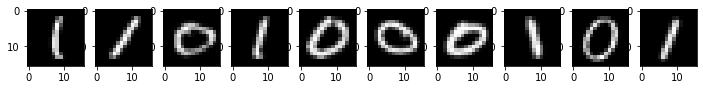

In [10]:
prediction(model, c=0)

ある程度の分類ができるようになっていると思います．\
うまく分類できているのが確認できたら，モデルのパラメータの代入部分
```python
model.load_state_dict(torch.load("params/model_state_dict.pth"), strict=False)
```
などをコメントアウトしてもう一度学習させてみましょう．
おそらく分類精度が悪くなってしまうのが確認できると思います

In [11]:
torch.save(model.state_dict(), "params/01_model_state_dict.pth")